In [1]:
import pandas as pd
from pyscipopt import Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = Model()

In [3]:
init_crew = pd.read_csv('data/Initial Crew.csv')
init_crew.head(100)

,Rating,Total
0,Boeing FO,418
1,Boeing C,406
2,Airbus FO,64
3,Airbus C,69
4,External Boeing FO,0
5,External Airbus FO,0


In [4]:
init_crew_B_F = init_crew[init_crew['Rating'] == 'Boeing FO']['Total'].item()
init_crew_B_C = init_crew[init_crew['Rating'] == 'Boeing C']['Total'].item()
init_crew_A_F = init_crew[init_crew['Rating'] == 'Airbus FO']['Total'].item()
init_crew_A_C = init_crew[init_crew['Rating'] == 'Airbus C']['Total'].item()
init_crew_B_F_E = init_crew[init_crew['Rating'] == 'External Boeing FO']['Total'].item()
init_crew_A_F_E = init_crew[init_crew['Rating'] == 'External Airbus FO']['Total'].item()

In [5]:
init_qual = pd.read_csv('data/Initial Crew Type Qualification.csv')

init_qual_B_F_1 = model.addVar(vtype="I", name=f'init_qual_B_F_1')
model.addCons(init_qual_B_F_1 == init_qual[(init_qual['Rating'] == 'Boeing FO') & (init_qual['Type'] == 1)]['Number Qualified'].astype(int).item())
init_qual_B_C_2 = model.addVar(vtype="I", name=f'init_qual_B_C_2')
model.addCons(init_qual_B_C_2 == init_qual[(init_qual['Rating'] == 'Boeing C') & (init_qual['Type'] == 2)]['Number Qualified'].astype(int).item())
init_qual_B_C_3 = model.addVar(vtype="I", name=f'init_qual_B_C_3')
model.addCons(init_qual_B_C_3 == init_qual[(init_qual['Rating'] == 'Boeing C') & (init_qual['Type'] == 3)]['Number Qualified'].astype(int).item())

init_qual_A_F_1 = model.addVar(vtype="I", name=f'init_qual_A_F_1')
model.addCons(init_qual_A_F_1 == init_qual[(init_qual['Rating'] == 'Boeing FO') & (init_qual['Type'] == 1)]['Number Qualified'].astype(int).item())
init_qual_A_C_2 = model.addVar(vtype="I", name=f'init_qual_A_C_2')
model.addCons(init_qual_A_C_2 == init_qual[(init_qual['Rating'] == 'Boeing C') & (init_qual['Type'] == 2)]['Number Qualified'].astype(int).item())
init_qual_A_C_3 = model.addVar(vtype="I", name=f'init_qual_A_C_3')
model.addCons(init_qual_A_C_3 == init_qual[(init_qual['Rating'] == 'Boeing C') & (init_qual['Type'] == 3)]['Number Qualified'].astype(int).item())



init_qual_B = [init_qual_B_F_1, init_qual_B_C_2, init_qual_B_C_3]
init_qual_A = [init_qual_A_F_1, init_qual_A_C_2, init_qual_A_C_3]

In [6]:
crew_leaving = pd.read_csv('data/Crew Leaving.csv').fillna(0)

cum_leaving = crew_leaving.cumsum()

# left in week per qual boeing
left_B_F_1 = cum_leaving['Boeing FO type 1 qual'].to_numpy()
left_B_C_2 = cum_leaving['Boeing C type 2 qual'].to_numpy()
left_B_C_3 = cum_leaving['Boeing C type 3 qual'].to_numpy()

# overall left for crew boeing
left_B_F = cum_leaving['Boeing FO no qual'].to_numpy() + left_B_F_1
left_B_C = cum_leaving['Boeing C no qual'].to_numpy() + left_B_C_2 + left_B_C_3

# left in week per qual airbus
left_A_F_1 = cum_leaving['Airbus FO type 1 qual'].to_numpy()
left_A_C_2 = cum_leaving['Airbus C type 2 qual'].to_numpy()
left_A_C_3 = cum_leaving['Airbus C type 3 qual'].to_numpy()

# overall left for crew aribus
left_A_F = cum_leaving['Airbus FO no qual'].to_numpy() + left_A_F_1
left_A_C = cum_leaving['Airbus C no qual'].to_numpy() + left_A_C_2 + left_A_C_3


left_B_qual = [left_B_F_1, left_B_C_2, left_B_C_3]
left_A_qual = [left_A_F_1, left_A_C_2, left_A_C_3]

In [7]:
demand = pd.read_csv('data/Crew Demand.csv')[['Week', 'Aircraft', 'Demand']]

dem_A_np = demand[demand['Aircraft'] == 'Airbus']['Demand'].to_numpy()
dem_B_np = demand[demand['Aircraft'] == 'Boeing']['Demand'].to_numpy()

dem_A = []
dem_B = []

for week in range(0, len(dem_A_np)):

    curr_dem_A = model.addVar(vtype="I", name=f'dem_A_{week}')
    model.addCons(curr_dem_A == dem_A_np[week], name=f'cons_dem_A_{week}')
    dem_A.append(curr_dem_A)

    curr_dem_B = model.addVar(vtype="I", name=f'dem_B_{week}')
    model.addCons(curr_dem_B == dem_B_np[week], name=f'cons_dem_B_{week}')
    dem_B.append(curr_dem_B)

In [8]:
# add simulator

simulators = pd.read_csv('data/Simulator Availability.csv')
sim_np = simulators['Available Simulators'].to_numpy()

availsim = []
for week in range(0, len(sim_np)):
    curr_availsim = model.addVar(vtype="I", name=f'availsim_{week}')
    model.addCons(curr_availsim == sim_np[week], name=f'cons_availsim_{week}')
    availsim.append(curr_availsim)

In [9]:
# add training calc

num_train_1 = []
num_train_2 = []
num_train_3 = []
num_train_4 = []
num_train_5 = []


# list of list of all influences of simulators
# then sum at the end
influences = [[] for i in range(len(sim_np) + 10)]

# upper limit by simulator availability
for week in range(0, len(sim_np)):

    train1 = model.addVar(vtype="I", name=f'num_train_1_{week}', lb=0)
    #model.addCons(2 * train1 <= sim_np[week + 4], name=f'num_train_1_sim_4_{week}')
    influences[week + 4].append(2*train1)
    num_train_1.append(train1)


    train2 = model.addVar(vtype="I", name=f'num_train_2_{week}', lb=0)
    #model.addCons(train2 <= sim_np[week + 1], name=f'num_train_2_sim_1_{week}')
    #model.addCons(train2 <= sim_np[week + 4], name=f'num_train_2_sim_4_{week}')
    influences[week + 1].append(train2)
    influences[week + 4].append(train2)

    num_train_2.append(train2)


    train3 = model.addVar(vtype="I", name=f'num_train_3_{week}', lb=0)
    #model.addCons(2*train3 <= sim_np[week + 5], name=f'num_train_3_sim_5_{week}')
    #model.addCons(2*train3 <= sim_np[week + 6], name=f'num_train_3_sim_6_{week}')
    #model.addCons(train3 <= sim_np[week + 9], name=f'num_train_3_sim_9_{week}')
    #model.addCons(2*train3 <= sim_np[week + 10], name=f'num_train_3_sim_10_{week}')
    influences[week + 5].append(2*train3)
    influences[week + 6].append(2*train3)
    influences[week + 9].append(train3)
    influences[week + 10].append(2*train3)

    num_train_3.append(train3)


    train4 = model.addVar(vtype="I", name=f'num_train_4_{week}', lb=0)
    #model.addCons(2 * train4 <= sim_np[week], name=f'num_train_4_sim_0_{week}')
    influences[week].append(2*train4)
    num_train_4.append(train4)

    train5 = model.addVar(vtype="I", name=f'num_train_5_{week}', lb=0)
    #model.addCons(2 * train5 <= sim_np[week], name=f'num_train_4_sim_0_{week}')
    #model.addCons(2 * train5 <= sim_np[week], name=f'num_train_4_sim_0_{week}')
    influences[week].append(2*train5)
    influences[week + 2].append(train5)

    num_train_5.append(train5)

num_train = [num_train_1, num_train_2, num_train_3, num_train_4, num_train_5]

In [10]:
# culminate all influences into constraints
# assumption: all trainings are finished by the end of the year

num_sim_used = []

for week in range(len(sim_np)):
    sim_used_week = model.addVar(vtype="I", name=f'num_sim_used_{week}')
    num_sim_used.append(sim_used_week)
    model.addCons(sim_used_week == sum(influences[week]))
    model.addCons(sim_used_week <= sim_np[week], name=f'cons_train_by_sim_{week}')

    remaining_weeks = len(sim_np) - week

    if remaining_weeks < 12:
        model.addCons(num_train_3[week] == 0, name=f'cons_train_3_must_finish_{week}')

        if remaining_weeks < 10:
            model.addCons(num_train_1[week] == 0, name=f'cons_train_1_must_finish_{week}')

            if remaining_weeks < 5:
                model.addCons(num_train_2[week] == 0, name=f'cons_train_2_must_finish_{week}')

                if remaining_weeks < 2:
                    model.addCons(num_train_5[week] == 0, name=f'cons_train_5_must_finish_{week}')

                    if remaining_weeks < 1:
                        model.addCons(num_train_4[week] == 0, name=f'cons_train_4_must_finish_{week}')


In [11]:
training_structure = pd.read_csv('data/Training.csv').fillna(0)
training_structure.head(100)

,Training Type,Week of Training,Type,Capacity Needed,Simulator Needed,Max Students,Capacity Gained,Unnamed: 7,Unnamed: 8
0,1,1,1,2,0.0,4,0.0,0.0,0.0
1,1,2,1,1,0.0,4,0.0,0.0,0.0
2,1,3,1,1,0.0,4,0.0,0.0,0.0
3,1,4,1,2,0.0,4,0.0,0.0,0.0
4,1,5,2,1,2.0,4,0.0,0.0,0.0
5,1,6,1,1,0.0,4,4.0,0.0,0.0
6,1,7,1,2,0.0,4,0.0,0.0,0.0
7,1,8,1,1,0.0,4,0.0,0.0,0.0
8,1,9,1,1,0.0,4,4.0,0.0,0.0
9,1,10,2,1,0.0,4,4.0,0.0,0.0


In [12]:
# add trainer calc
# again via influences

num_trainer_vars = [[[],[],[]]] * 2

print(len(num_trainer_vars[0]))

# list of list of all influences for each airbus and boeing
# then sum at the end
# first airbus, second boeing
trainer_influences = [[[[],[],[]] for i in range(len(sim_np) + 12)]] * 2

# train 0, 2, 4 require airbus trainer
# train 1, 3 require boeing
for training_type in range(0, 5):

    aircraft_idx = training_type % 2

    trainer_types = training_structure[training_structure['Training Type'] == training_type + 1]['Type']
    trainer_req_cap = training_structure[training_structure['Training Type'] == training_type + 1]['Capacity Needed']

    # upper limit by qual availability

    for week in range(0, len(sim_np)):

        #num_trainer = model.addVar(vtype="I", name=f'num_trainer_{training_type}_{week}', lb=0)

        for i, (curr_type, curr_req_cap) in enumerate(zip(trainer_types, trainer_req_cap)):
            trainer_influences[aircraft_idx][week + i][curr_type - 1].append(curr_req_cap * num_train[training_type][week])
        
        #num_trainer_vars[training_type].append(num_train[training_type][week] * num_trainer)

3


In [13]:
# culminate all influences into constraints
# assumption: all trainings are finished by the end of the year
# training_type 0, 2, 4 require only airbus
# training_type 1, 3 require only boing

# calculate currently active number of trainers per week
for week in range(len(sim_np)):
    for trainer_type in range(3):
        num_trainer_A = model.addVar(vtype="I", name=f'num_trainer_A_{week}')
        num_trainer_vars[0][trainer_type].append(num_trainer_A)
        model.addCons(num_trainer_A == sum(trainer_influences[0][week][trainer_type]))

        num_trainer_B = model.addVar(vtype="I", name=f'num_trainer_B_{week}')
        num_trainer_vars[1][trainer_type].append(num_trainer_B)
        model.addCons(num_trainer_B == sum(trainer_influences[1][week][trainer_type]))

        model.addCons(num_trainer_A <= init_qual_A[trainer_type] - left_A_qual[trainer_type][week], name=f'cons_train_by_trainer_A_{trainer_type}_{week}')
        model.addCons(num_trainer_B <= init_qual_B[trainer_type] - left_B_qual[trainer_type][week], name=f'cons_train_by_trainer_B_{trainer_type}_{week}')



In [14]:
# add students
# assumption: becoming a student and on does not interfer with being qualified

student_vars = [[] for _ in range(5)]

init_num_candidates_per_training = [init_crew_B_F - left_B_F,
                               init_crew_B_F - left_B_F,
                               init_crew_B_C - left_B_C,
                               init_crew_B_F_E * np.ones_like(left_B_F), 
                               init_crew_A_F_E * np.ones_like(left_B_F)] # TODO add the hiring counts here

# regain influence lists for per week per class regain variables
# AF, AC, BF, BC, placeholder if no regain is intended
# TODO replace placeholder with hiring -> B FO ext, A FO ext

training_target_regain = [[[],[],[],[],[0],[0]] for i in range(len(sim_np) + 12)]
training_type_target_index = [0, 3, 1, 2, 0]

for training_type in range(5):

    max_stud = training_structure[training_structure['Training Type'] == training_type + 1]['Max Students']
    max_stud = max_stud.to_numpy()[0]

    regain_idx = training_structure[(training_structure['Training Type'] == training_type + 1) & (training_structure['Capacity Gained'] != 0)]['Week of Training'] - 1
    regain_idx = regain_idx.to_numpy()
    
    for week in range(len(sim_np)):

        # number of students in training started in a week
        student_var = model.addVar(vtype="I", name=f'num_stud_{training_type}_{week}', lb=0)
        model.addCons(student_var <= max_stud * num_train[training_type][week], name='cons_limit_student_by_num_train_max_stud')
        student_vars[training_type].append(student_var)

        # for specific weeks while training we get some capacity back
        for idx in regain_idx:
            training_target_regain[week + idx][training_type_target_index[training_type]].append(student_var)
        
        # also for the whole time after the training concludes, we have a permanent regain
        # get length of training
        train_length = training_structure[training_structure['Training Type'] == training_type + 1]['Week of Training'].max()
        
        for finished_week in range(week + train_length, len(sim_np)):
            training_target_regain[finished_week][training_type_target_index[training_type]].append(student_var)
        

training_type_student_index = [2, 2, 3, 4, 5]

for training_type in range(5):

    sum_prev_stud = 0
    sum_regained_stud = 0
    aircraft_idx = training_type % 2
    
    for week in range(len(sim_np)):

        num_possible_students = init_num_candidates_per_training[training_type][week] - sum_prev_stud + sum_regained_stud
        
        # TODO after split in trainer constraint, only use the correct one here as well
        # split qualifications type 1 in Airbus vs type 1 in Boeing
        # if training works with FO students, all trainers removed of type 1 are relevant

        # subtract the trainers bound by trainings

        # if FO are targeted students how many FO of the specific aircraft are in a training
        if training_type in [0, 1]:
            num_possible_students = num_possible_students - num_trainer_vars[aircraft_idx][0][week]

        # if C are targeted students how many C of the specific aircraft are in a training
        elif training_type == 2:
            num_possible_students = num_possible_students - num_trainer_vars[aircraft_idx][1][week] + num_trainer_vars[aircraft_idx][2][week]

        # TODO 
        model.addCons(student_vars[training_type][week] <= num_possible_students, name=f'cons_limit_student_by_avail_crew_{training_type}_{week}')

        sum_prev_stud += student_vars[training_type][week]


        sum_regained_stud += sum(training_target_regain[week][training_type_student_index[training_type]])


In [15]:
# add remaining available crew

# flight ready crews Boeing FO C, Airbus FO C 
avail_crews = [[],[],[],[]]


for week in range(len(sim_np)):


    active_trainers_b_f = num_trainer_vars[1][0][week]
    active_trainers_b_c = num_trainer_vars[1][1][week] + num_trainer_vars[1][2][week]

    active_trainers_a_f = num_trainer_vars[0][0][week]
    active_trainers_a_c = num_trainer_vars[0][1][week] + num_trainer_vars[0][2][week]


    overall_students_b_f = sum(student_vars[0][:week+1]) + sum(student_vars[1][:week+1])
    overall_students_b_c = sum(student_vars[2][:week+1])

    overall_students_a_f = 0
    overall_students_a_c = 0


    cap_regain_b_f = sum(training_target_regain[week][2])
    cap_regain_b_c = sum(training_target_regain[week][3])
    cap_regain_a_f = sum(training_target_regain[week][0])
    cap_regain_a_c = sum(training_target_regain[week][1])


    ########### maybe add variables for students currently in training, trainers currently in training to prevent recalc

    avail_b_f = model.addVar(vtype='I', name=f'avail_crew_B_F_{week}')
    avail_crews[0].append(avail_b_f)


    # available Boeing FO are initial - left by plan - overall students from training 0,1 - active trainers + the capacity regained from training 3
    model.addCons(avail_b_f == init_crew_B_F - left_B_F[week] - overall_students_b_f - active_trainers_b_f + cap_regain_b_f, name=f'cons_crew_b_f_complete_{week}')



    avail_b_c = model.addVar(vtype='I', name=f'avail_crew_B_C_{week}')
    avail_crews[1].append(avail_b_c)

    # available Boeing C are initial - left by plan - overall students from training 2 - active trainers training 1 type 1 and 2 + the capacity regained from training 1
    model.addCons(avail_b_c == init_crew_B_C - left_B_C[week] - overall_students_b_c - active_trainers_b_c + cap_regain_b_c, name=f'cons_crew_b_c_complete_{week}')



    avail_a_f = model.addVar(vtype='I', name=f'avail_crew_A_F_{week}')
    avail_crews[2].append(avail_a_f)

    # available Airbus FO are initial - left by plan - active trainers + the capacity regained from training 0,4
    model.addCons(avail_a_f == init_crew_A_F - left_A_F[week] - overall_students_a_f - active_trainers_a_f + cap_regain_a_f, name=f'cons_crew_a_f_complete_{week}')



    avail_a_c = model.addVar(vtype='I', name=f'avail_crew_A_C_{week}')
    avail_crews[3].append(avail_a_c)

    # available Airbus C are initial - left by plan - active trainers + the capacity regained from training 0,4
    model.addCons(avail_a_c == init_crew_A_C - left_A_C[week] - overall_students_a_c - active_trainers_a_c + cap_regain_a_c, name=f'cons_crew_a_c_complete_{week}')



In [16]:
# add grounded planes calc

grounded_A_vars = []
grounded_B_vars = []

for week in range(len(sim_np)):

    grounded_A = model.addVar(vtype="I", name=f'grounded_A_{week}', lb=0)
    grounded_A_vars.append(grounded_A)
    model.addCons(grounded_A >= dem_A[week] - avail_a_f, name=f'cons_grounded_A_F_{week}')
    model.addCons(grounded_A >= dem_A[week] - avail_a_c, name=f'cons_grounded_A_C_{week}')
    model.addCons(grounded_A <= dem_A[week], name=f'cons_grounded_A_by_demand_{week}')

    grounded_B = model.addVar(vtype="I", name=f'grounded_B_{week}', lb=0)
    grounded_B_vars.append(grounded_B)
    model.addCons(grounded_B >= dem_B[week] - avail_b_f, name=f'cons_grounded_B_F_{week}')
    model.addCons(grounded_B >= dem_B[week] - avail_b_c, name=f'cons_grounded_B_C_{week}')
    model.addCons(grounded_B <= dem_B[week], name=f'cons_grounded_B_by_demand_{week}')

In [17]:
# add grounded cost

In [18]:
# set cost minimization

In [19]:
# add EOY requirement

In [20]:
# add hiring option

In [21]:
model.redirectOutput()
#model.printProblem()

In [22]:
#model.setObjective(sum(num_train_1) + sum(num_train_2) + sum(num_train_3) + sum(num_train_4) + sum(num_train_5), 'maximize')

# most students
#model.setObjective(sum([ var for t in range(5) for var in student_vars[t]]), 'maximize')

# minimal grounded planes
#model.setObjective(sum(grounded_A_vars) + sum(grounded_B_vars), 'minimize')

# maximize B C
model.setObjective(avail_crews[1][-1], 'maximize')
#model.setObjective(sum(num_trainer_vars[1][1]), 'minimize')

In [23]:
model.optimize()

presolving:
(round 1, fast)       791 del vars, 1227 del conss, 144 add conss, 1911 chg bounds, 1 chg sides, 0 chg coeffs, 0 upgd conss, 16 impls, 21 clqs
(round 2, fast)       1026 del vars, 1598 del conss, 224 add conss, 1912 chg bounds, 66 chg sides, 0 chg coeffs, 0 upgd conss, 17 impls, 21 clqs
(round 3, fast)       1076 del vars, 1726 del conss, 224 add conss, 1913 chg bounds, 177 chg sides, 9 chg coeffs, 0 upgd conss, 26 impls, 21 clqs
(round 4, fast)       1136 del vars, 1767 del conss, 224 add conss, 1913 chg bounds, 190 chg sides, 21 chg coeffs, 0 upgd conss, 26 impls, 18 clqs
(round 5, fast)       1198 del vars, 1851 del conss, 224 add conss, 1913 chg bounds, 205 chg sides, 33 chg coeffs, 0 upgd conss, 26 impls, 8 clqs
(round 6, fast)       1290 del vars, 2002 del conss, 224 add conss, 1913 chg bounds, 233 chg sides, 52 chg coeffs, 0 upgd conss, 26 impls, 6 clqs
(round 7, fast)       1292 del vars, 2017 del conss, 224 add conss, 1913 chg bounds, 244 chg sides, 52 chg coeffs, 

In [24]:
model.printBestSol()

objective value:                                  515
init_qual_B_F_1                                    12 	(obj:0)
init_qual_B_C_2                                    14 	(obj:0)
init_qual_B_C_3                                     8 	(obj:0)
init_qual_A_F_1                                    12 	(obj:0)
init_qual_A_C_2                                    14 	(obj:0)
init_qual_A_C_3                                     8 	(obj:0)
dem_A_0                                            33 	(obj:0)
dem_B_0                                           196 	(obj:0)
dem_A_1                                            32 	(obj:0)
dem_B_1                                           194 	(obj:0)
dem_A_2                                            46 	(obj:0)
dem_B_2                                           202 	(obj:0)
dem_A_3                                            31 	(obj:0)
dem_B_3                                           185 	(obj:0)
dem_A_4                                            40 	(obj:0)
d

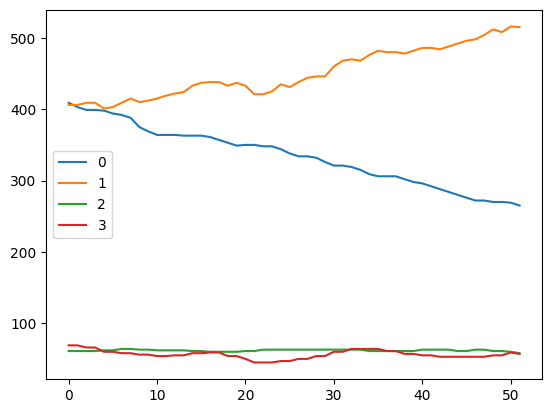

In [25]:
# plot avail boeing fo

# TODO check warum wird rot weniger? wird teils airbus personal fuer boeing benutzt?

for i in range(4):
    stats = []
    for week in range(52):
        stats.append(model.getVal(avail_crews[i][week]))

    plt.plot(stats, label=f'{i}')

plt.legend()

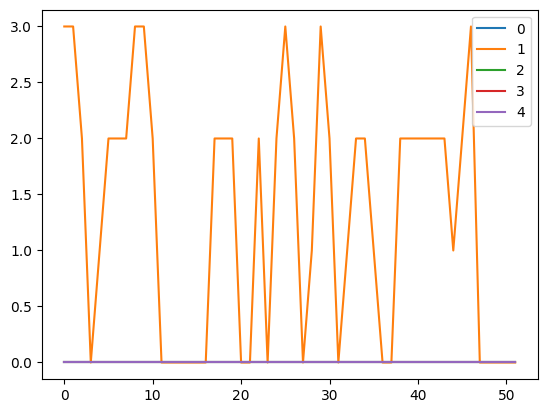

In [26]:
for i in range(5):
    stats = []
    for week in range(52):
        stats.append(model.getVal(num_train[i][week]))

    plt.plot(stats, label=f'{i}')
plt.legend()

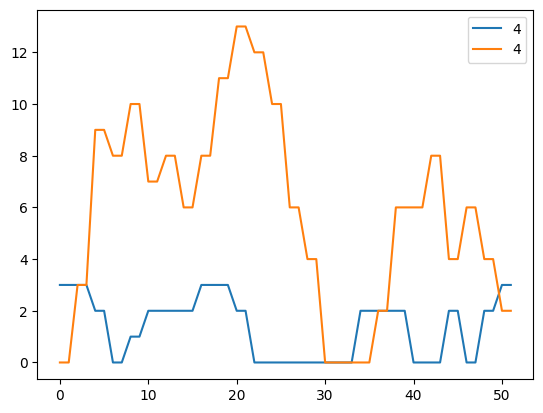

In [ ]:
for type in range(2):
    stats = []
    for week in range(52):
        stats.append(model.getVal(num_trainer_vars[0][type][week]))

    plt.plot(stats, label=f'{type}')
plt.legend()